In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import binarize
from colorsys import hsv_to_rgb
from random import randint, uniform
from sklearn.metrics import mean_absolute_error as MAE


%matplotlib inline

In [ ]:
tops = pd.read_csv(r"teapot_clean_JRP.csv", index_col=[0]) #read in the top data
tops.rename(columns={'TVDSS':'SS'}, inplace=True)

ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin #standardize the subsea values

tops.dropna(inplace=True)
#tops.drop(['MD', 'GL', 'DELEV', 'DT'], axis=1, inplace=True)
def sample_splitter(dataframe, fraction, randomseed):
    test = dataframe.sample(frac=fraction, random_state=randomseed)
    test_idx = test.index.values
    train =  dataframe.drop(test_idx)
    return train, test

train, test = sample_splitter(tops, 0.2, 86)

print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
R = D_df.values
A = binarize(R) 


#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    #print("Initiating ")
    lambda_ = lambda_
    n_factors = n_factors
    n, m = A.shape
    n_iterations = n_iterations
    np.random.seed(86)
    Users = 5 * np.random.rand(n, n_factors, )
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MAE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
     #   print(
     #       "Error after solving for User Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
     #   print(
     #       "Error after solving for Item Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        MAE_List.append(get_error(A, Users, Items, R))
     #   print("%sth iteration is complete..." % iter)
    
   # print(MSE_List)
   # fig = plt.figure()
   # ax = fig.add_subplot(111)
   # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
   # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    return Users, Items

U, Vt = runALS(R, A, 4, 10, 0.1)

recommendations = np.dot(U, Vt) #get the recommendations

recsys = pd.DataFrame(
    data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
) #results

newDF = recsys.T
newDF.reset_index(inplace=True)

flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

new_df.rename(columns={0:'SS_pred'}, inplace=True)

cleanDF = new_df.dropna()

cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

print(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

In [83]:
def cross_validation(dataframe, random_seed, latent_vectors, n_iters):
    np.random.seed(random_seed)
    block_1  = np.random.choice(dataframe.index, size=dataframe.shape[0]//4)
    tops2 = dataframe.drop(block_1)
    block_2 = np.random.choice(tops2.index, size=tops.shape[0]//4)
    tops3 = tops2.drop(block_2)
    block_3 = np.random.choice(tops3.index, size=tops.shape[0]//4)
    tops4 = tops3.drop(block_3)
    block_4 = np.random.choice(tops4.index, size=tops.shape[0]//4)
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

        CV_MAE.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

    return CV_MAE

In [102]:
%%capture
grid_search = {}

for L in range(1,10):
    for n_it in range(10,100,10):
        grid_search[L,n_it] = np.mean(cross_validation(tops, 86, L, n_it))


In [103]:
min(grid_search, key=grid_search.get)

(3, 40)

In [105]:
from sklearn.metrics import mean_squared_error as MSE
np.sqrt(MSE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))


32.48786314526637

In [109]:
np.mean(cross_validation(tops, 86, 3, 40))

Validating on 1668 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 1668 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 1668 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 1668 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


14.480056746663385

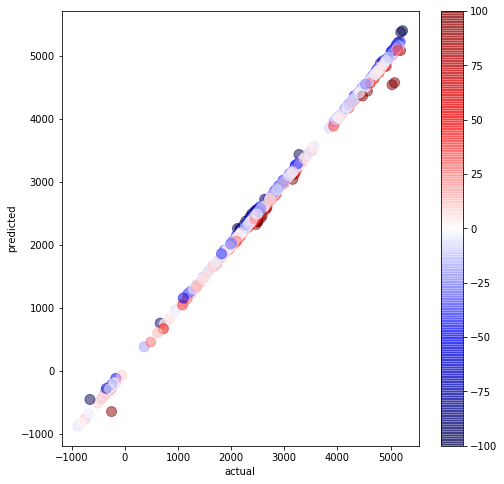

In [110]:
plt.figure(figsize=(8,8))
plt.scatter(cleanDF.SS+ssmin, cleanDF.SS_pred+ssmin, c=cleanDF.signed_error, vmin=-100,vmax=100, 
            cmap='seismic', s=100, alpha=0.5)
plt.plot()
plt.xlabel('actual')
plt.ylabel('predicted')
plt.colorbar()

In [111]:
well_locs = pd.read_csv(r'TeapotDomeWellHeaders.csv')
well_locs.rename(columns={'API Number':'API'}, inplace=True)

locationDF = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

strat_order = ['SSXS', 'SSXbase','SHNNu', 'SHNNl','SHNNbs','StBR','StFT','StGD','StAM','StTC','NBRRws','NBRRsg','CRLL',
                'F1WC','B1',
'F1WCBench1Base', 'F1WCBench2Top', 'F1WCBench2Base', 'F1WCBench3Top',
'F1WCbase','F2WC','F2WCbase',
'F3WC',
'F3WCbase',
'MWRY',
'MDDY',
'THRM',
'DKOT',
'LKOT', # base cret
'MRSN',
'SNDCu',# upper sundance
'CNSP', # base jurassic canyon spring
'CRMT', # Crow mountain, Chugwater Group/FM
'ALCV', # Alcova ls, chugwater
'RDPK', # base Triassic chugwater
'ERVY', # goose egg member
'FRLL', # goose egg
'GLND', # goose egg
'MNKT', # goose egg
'OPCH', # goose egg Base Permian
'A Sand', # Tensleep 
'B Dolo',
'B Sand',
'C1 Dolo',
'C1 Sand',
'C2 Dolo',
'C2 Sand',
'C3 Dolo',
'C3 Sand',
'C4 Dolo',
'C4 Sand',
'D Dolo',
'D Sand',
'E Dolo',
'AMSD', # base Pennsylvanian
'MDSN', # base mississippian
'PC'
]

color_list = []
for i in range(len(strat_order)):
    if i <=29: #cretaceous
        h = uniform(83/360, 158/360) # Select random green'ish hue from hue wheel
        s = uniform(0.8, 1)
        v = uniform(0.2, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
    elif 29<i<=32: #Jurassic
        h = uniform(138/360, 200/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 32<i<=35: #triassic
        h = uniform(156/360, 180/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 35<i<= 40: #permian
        h = uniform(190/360, 200/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 40<i<= 55: #Pennsylvanian
        h = uniform(210/360, 230/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 55<i<= 56: #missippian
        h = uniform(240/360, 260/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    else: #PC
        h = uniform(300/360, 320/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

colors_to_plot = dict(zip(strat_order, color_list))

mae_errors = []
n_picks = []
formed = []
colors = []
for formation in strat_order:
    form = locationDF[locationDF['Formation'] == formation]
    
    try:
        print(str(formation)+' mean absolute error is '+str(round(MAE(form.SS.values-ssmin, form.SS_pred.values-ssmin),1))
          +' n holdout='+str(form.shape[0])+' n picks='+str(original_picks[formation]))
        mae_errors.append(round(MAE(form.SS.values-ssmin, form.SS_pred.values-ssmin),1))
        n_picks.append(original_picks[formation])
        formed.append(formation)
        colors.append(colors_to_plot[formation])
    except:
        print(str(formation)+' has no holdout samples')

SSXS has no holdout samples
SSXbase has no holdout samples
SHNNu has no holdout samples
SHNNl has no holdout samples
SHNNbs has no holdout samples
StBR has no holdout samples
StFT has no holdout samples
StGD has no holdout samples
StAM has no holdout samples
StTC has no holdout samples
NBRRws has no holdout samples
NBRRsg has no holdout samples
CRLL has no holdout samples
F1WC has no holdout samples
B1 has no holdout samples
F1WCBench1Base has no holdout samples
F1WCBench2Top has no holdout samples
F1WCBench2Base has no holdout samples
F1WCBench3Top has no holdout samples
F1WCbase has no holdout samples
F2WC has no holdout samples
F2WCbase has no holdout samples
F3WC has no holdout samples
F3WCbase has no holdout samples
MWRY has no holdout samples
MDDY has no holdout samples
THRM has no holdout samples
DKOT has no holdout samples
LKOT has no holdout samples
MRSN has no holdout samples
SNDCu has no holdout samples
CNSP has no holdout samples
CRMT has no holdout samples
ALCV has no hold

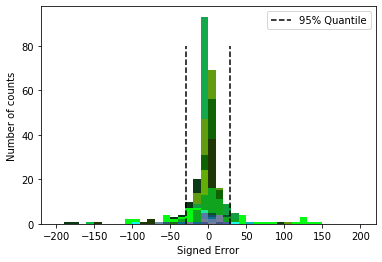

In [112]:
for formation in strat_order:
    form = locationDF[locationDF['Formation'] == formation]
    plt.hist(form.signed_error, range=(-200,200), bins=40, stacked=True, color=colors_to_plot[formation])
plt.vlines(locationDF.quantile(0.05).signed_error, 0,80, linestyle='dashed') #95% of the picks are within these
plt.vlines(locationDF.quantile(0.95).signed_error, 0,80, linestyle='dashed', label='95% Quantile')
plt.xlabel('Signed Error')
plt.ylabel('Number of counts')
plt.legend()

Text(0, 0.5, 'MAE')

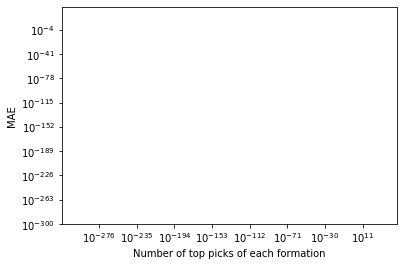

In [113]:
nums = dict(zip(formed, n_picks))
errers = dict(zip(formed, mae_errors))

plt.scatter(n_picks, mae_errors, c=colors, label=formed)
plt.semilogx()
plt.semilogy()
plt.xlabel('Number of top picks of each formation')
plt.ylabel('MAE')


In [114]:
locationDF_full = tops.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
predictions = flat_preds.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

signed = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

This is test size error calculation

In [ ]:
big_de_error = []
for ran in range(100):
    de_error = []
    for i in np.arange(0.99, 0, -0.1):
        train, test = sample_splitter(tops, i, ran)
        print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')
        D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        from sklearn.preprocessing import binarize
        A = binarize(R) 
        U, Vt = runALS(R, A, 3, 20, 0.1)
        recommendations = np.dot(U, Vt) #get the recommendations
        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results
        newDF = recsys.T
        newDF.reset_index(inplace=True)
        #test = newDF[["FORT UNION", "API"]]
        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()
        new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])
        new_df.rename(columns={0:'SS_pred'}, inplace=True)
        cleanDF = new_df.dropna()
        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])
        de_error.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

        locationDF = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
    big_de_error.append(de_error)
    
'''
        for formation in strat_order:
            form = locationDF[locationDF['Formation'] == formation]
            plt.hist(form.signed_error, range=(-200,200), bins=40, stacked=True, color=colors_to_plot[formation])
        plt.vlines(locationDF.quantile(0.05).signed_error, 0,80, linestyle='dashed') #95% of the picks are within these
        plt.vlines(locationDF.quantile(0.95).signed_error, 0,80, linestyle='dashed', label='95% Quantile')
        plt.xlabel('Signed Error')
        plt.ylabel('Number of counts')
        plt.legend()
        plt.show()
        plt.clf()
'''

Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations
Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations
Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


In [ ]:
plt.plot(np.arange(0.01,1,0.1), de_error, c='k', marker='o')
plt.ylim(1,2500)
plt.semilogy()
plt.ylabel('Mean Absolute Error (ft)')
plt.xlabel('Percent of dataset used to train')
#plt.savefig(r'E:\UT Austin\Manuscripts\RecSys\Figures\working\testvstrain.pdf')

### Now let's hold out one well and slowly add in tops for it

In [ ]:
ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin #standardize the subsea values
from sklearn.metrics import mean_absolute_error as MAE

tops.dropna(inplace=True)

def well_sample_splitter(dataframe, master_dataframe, number_of_tops, randomseed):
    test = dataframe.sample(n=number_of_tops, random_state=randomseed)
    test_idx = test.index.values
    train =  master_dataframe.drop(test_idx)
    return train, test

well_errors = []
for well in range(100):
    moving_well = tops[tops.API == tops.API.unique()[well]]
    errors = []
    for i in range(1, moving_well.shape[0], 1):

        train, test = well_sample_splitter(moving_well, tops, i, 86)

        #print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

        D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        from sklearn.preprocessing import binarize
        A = binarize(R) 
        U, Vt = runALS(R, A, 3, 20, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

        errors.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))
    print(f'Done with {well+1} wells')
    well_errors.append(errors)

### How about Pyvista?

In [ ]:
import pyvista as pv
import panel
from itkwidgets import view
panel.extension("vtk")
pv.set_plot_theme("document")

In [ ]:
combo

In [ ]:
wrong = []
for well in predictions.API.unique():
    test_well = predictions[predictions.API ==well].sort_values(0, ascending=False).Formation
    incorrect = 0
    for i in range(len(test_well)):
        combo = list(zip(test_well.values, strat_order))
        if combo[i][0] != combo[i][1]:
            incorrect+=1
        else:
            incorrect+=0
    wrong.append(incorrect)


In [ ]:
gl = tops
surface = gl.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
cloud = pv.PolyData(np.array(list(zip(surface.Easting, surface.Northing, surface.GL))))
surf = cloud.delaunay_2d()

In [ ]:
plotter = pv.Plotter(notebook=False)
for formation in strat_order:
    subpreds = predictions[predictions['Formation'] == formation]
    points = np.array(list(zip(subpreds.Easting, subpreds.Northing, subpreds[0])))
    if points.shape[0] > 0:
        pc = pv.PolyData(points)
    #data = tops_predicted[i][:,-1]
    #pc['elevation'] = data
    plotter.add_points(pc, color=colors_to_plot[formation])#color=[r,g,b])
plotter.add_mesh(surf)
plotter.set_scale(1,1,2, 0) #V.E.
plotter.show()